<h2 align=center> Optimize TensorFlow Models For Deployment with TensorRT</h2>

In this project, you will learn how to use the TensorFlow integration for TensorRT (also known as TF-TRT) to increase inference performance.

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with Deep Learning, and understand what **inference** is
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and TensorRT Runtime
- **[Task 3]()**: Load the Data and Pre-trained Model
- **[Task 4]()**: Create Batched Input
- **[Task 5]()**: Load TensorFlow SavedModel
- **[Task 6]()**: Get Baseline for Prediction Throughput and Accuracy
- **[Task 7]()**: Convert a TensorFlow saved model into a TF-TRT Float32 Optimized Graph
- **[Task 8]()**: Benchmark TF-TRT Float32
- **[Task 9]()**: Convert to TF-TRT Float16 and Benchmark
- **[Task 10]()**: TF-TRT INT8 Model
- **[Task 11]()**: Converting to TF-TRT INT8
- **[Task 12]()**: Benchmark TF-TRT INT8

In [ ]:
!nvidia-smi

Mon Aug  7 04:47:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python3 -m pip install --upgrade tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16972 sha256=40a3d94534196ff5e58ff4e23dfbb0c71d834f507a3a6ff174c84507918dfcdb
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [ ]:
# check TensorRT version
import tensorflow as tf
import tensorrt
print("TensorFlow version: ", tf.version.VERSION)
print("TensorRT version: ",tensorrt.__version__)
!dpkg -l | grep nvinfer

TensorFlow version:  2.12.0
TensorRT version:  8.6.1


In [ ]:
# Re-run after Kernel restart
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

## Task 3: Load the Data and Pre-trained Model

### Data
We download several random images for testing from the Internet.

In [ ]:
!mkdir ./data
!wget  -qO ./data/img0.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg/640px-Golden_Retriever_Carlos_%2810581910556%29.jpg"
!wget  -qO ./data/img1.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg/407px-Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg"
!wget  -qO ./data/img2.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ostrich_male_RWD.jpg/636px-Ostrich_male_RWD.jpg"
!wget  -qO ./data/img3.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG/360px-Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG"

mkdir: cannot create directory ‘./data’: File exists


### Model

Thoughout this project, we will be using InceptionV3. Here we import the model from Keras.

In [ ]:
model = tf.keras.applications.InceptionV3(weights='imagenet')

1/1 [==============================] - 16s 16s/step
./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', 0.7223458), ('n02099712', 'Labrador_retriever', 0.12011401), ('n02104029', 'kuvasz', 0.02144006)]
1/1 [==============================] - 0s 27ms/step
./data/img1.JPG - Predicted: [('n01608432', 'kite', 0.9786083), ('n01807496', 'partridge', 0.0015346042), ('n01798484', 'prairie_chicken', 0.0006949869)]
1/1 [==============================] - 0s 27ms/step
./data/img2.JPG - Predicted: [('n01518878', 'ostrich', 0.93107945), ('n02018795', 'bustard', 0.0021012065), ('n02437616', 'llama', 0.00084432267)]
1/1 [==============================] - 0s 28ms/step
./data/img3.JPG - Predicted: [('n03902125', 'pay-phone', 0.98863846), ('n03187595', 'dial_telephone', 0.008258059), ('n02977058', 'cash_machine', 4.4076634e-05)]


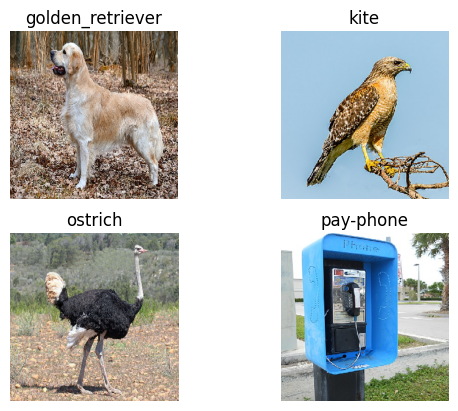

In [ ]:
def show_predictions(model):
  for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])
show_predictions(model)

When we benchmark our optimized TF-TRT models, they will be saved TensorFlow (not Keras) models. In order to have a fair comparison, here we save our Keras model as a TensorFlow model

In [ ]:
# Save the entire model as a TensorFlow SavedModel.
model.save('inception',save_format='tf')

## Task 4: Create Batched Input

Using **batch inference** to send many images to the GPU at once promotes parallel processing and improve throughput.

The `batch_input` helper function takes a batch_size, and returns a tensor with the preprocessed images.

In [ ]:
# Re-run after Kernel restart
def batch_input(image_paths, batch_size, target_size=(299, 299)):
    num_images = len(image_paths)
    batches = (num_images + batch_size - 1) // batch_size

    input_images = []

    for i in range(batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_images)
        batch_paths = image_paths[start_idx:end_idx]

        batch_images = []
        for img_path in batch_paths:
            img = image.load_img(img_path, target_size=target_size)
            x = image.img_to_array(img)
            x = preprocess_input(np.expand_dims(x, axis=0))
            batch_images.append(x)

        input_images.append(np.vstack(batch_images))

    return tf.convert_to_tensor(np.vstack(input_images), dtype=tf.float32)

# Example usage
batch_size = 4
image_paths = ['./data/img0.JPG', './data/img1.JPG', './data/img2.JPG', './data/img3.JPG']
batch_tensor = batch_input(image_paths, batch_size)


In [ ]:
print(batch_tensor.shape)

(4, 299, 299, 3)


## Task 5: Load TensorFlow SavedModel

In [ ]:
# Re-run after Kernel restart

# Load the TensorFlow SavedModel
loaded_model = tf.keras.models.load_model('inception')


Here we load a previously saved InceptionV3 model.

## Task 6: Get Baseline for Prediction Throughput and Accuracy

### Naive Inference with TensorFlow 2

The following will serve as a baseline for prediction throughput and accuracy. Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

The helper function `predict_and_benchmark_throughput` will use the passed in model to perform predictions on the passed in batched input over a number of runs. It measures and reports throughput, as well as time for ranges of runs.

Due to GPU initialization operations, we do not want to profile against initial inference -- so we can set a number of warmup runs to perform prior to benchmarking.

`predict_and_benchmark_throughput` returns the predictions for all images for all runs, after the warmup.

In [ ]:
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000):
    elapsed_time = []
    all_preds = []
    batch_size = batched_input.shape[0]

    for i in range(N_warmup_run):
        preds = infer(batched_input)
        all_preds.append(preds)

    for i in range(N_run):
        start_time = time.time()

        preds = infer(batched_input)

        end_time = time.time()

        elapsed_time = np.append(elapsed_time, end_time - start_time)

        all_preds.append(preds)

        if i % 50 == 0:
            print('Steps {}-{} average: {:4.1f}ms'.format(i, i + 50, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
    return all_preds


In [ ]:
def inference(input_data):
    return loaded_model.predict(input_data)

# Perform benchmarking and prediction
predictions = predict_and_benchmark_throughput(batch_tensor, inference,N_run=1)

1/1 [==============================] - 0s 29ms/step
Steps 0-50 average: 91.9ms
Throughput: 44 images/s


### Observe Accuracy

**NOTE:** We are not so concerned in this project about the accuracy of our predictions per se, only that they remain consistent as we optimize our models.

1/1 [==============================] - 0s 30ms/step
./data/img0.JPG - Predicted 1: golden_retriever with probability: 0.72
./data/img0.JPG - Predicted 2: Labrador_retriever with probability: 0.12
./data/img0.JPG - Predicted 3: kuvasz with probability: 0.02


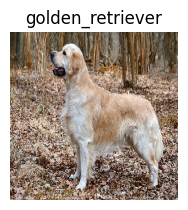

In [ ]:
def show_predictions(model):
    img_path = './data/img0.JPG'  # golden_retriever
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)

    preds = model.predict(x)  # Perform inference

    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    decoded_preds = decode_predictions(preds, top=3)[0]
    for i, (class_id, description, probability) in enumerate(decoded_preds):
        print('{} - Predicted {}: {} with probability: {:.2f}'.format(img_path, i + 1, description, probability))

    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(decoded_preds[0][1])

show_predictions(loaded_model)

Before going to the next Task, please make sure to clear GPU memory

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Network Transformation

TF-TRT performs several important transformations and optimizations to the neural network graph. First, layers with unused outputs are eliminated to avoid unnecessary computation. Next, where possible, convolution, bias, and ReLU layers are fused to form a single layer.

**Figure (a)** shows a typical convolutional network before optimization and

**Figure (c)** shows the result of this vertical layer fusion on the original network from Figure (a) (fused layers are labeled CBR). Layer fusion improves the efficiency of running TF-TRT networks on the GPU.

**Figure (b)** Another transformation is horizontal layer fusion, or layer aggregation, along with the required division of aggregated layers to their respective outputs, as Figure (b) shows.

Horizontal layer fusion improves performance by combining layers that take the same source tensor and apply the same operations with similar parameters, resulting in a single larger layer for higher computational efficiency. The example in Figure (b) shows the combination of 3 1×1 CBR layers from Figure (c) that take the same input into a single larger 1×1 CBR layer. Note that the output of this layer must be disaggregated to feed into the different subsequent layers from the original input graph.

*Source*: [Speed up TensorFlow Inference on GPUs with TensorRT](https://blog.tensorflow.org/2018/04/speed-up-tensorflow-inference-on-gpus-tensorRT.html)

<div align="center">
    <img width="700px" src='https://2.bp.blogspot.com/-nc-poLV8CNc/XhOI1wfgGjI/AAAAAAAACQI/3FlNTSKKrqMyTzR5XC5RCNnVuUY5EGmhQCLcBGAsYHQ/s1600/fig2.png' />
    <p style="text-align: center;color:gray">Figure (a): An example convolutional  model with multiple convolutional and activation layers before optimization</p>
    <p style="text-align: center;color:gray">Figure (c): Horizontal layer fusion</p>
</div>

[Source](https://www.slideshare.net/cfregly/advanced-spark-and-tensorflow-meetup-20170506-reduced-precision-fp16-int8-inference-on-convolutional-neural-networks-with-tensorrt-and-nvidia-pascal-from-chris-gottbrath-nvidia): Advanced Spark and TensorFlow Meetup 2017-05-06 Reduced Precision (FP16, INT8) Inference on Convolutional Neural Networks with TensorRT and NVIDIA Pascal from Chris Gottbrath, Nvidia

<div align="center">
    <img width="600px" src='https://image.slidesharecdn.com/tensorrt-for-spark-tensorflow-meetup-final-170408190710/95/advanced-spark-and-tensorflow-meetup-20170506-reduced-precision-fp16-int8-inference-on-convolutional-neural-networks-with-tensorrt-and-nvidia-pascal-from-chris-gottbrath-nvidia-45-638.jpg' />
    <p style="text-align: center;color:gray"> Figure (c). Horizontal layer fusion </p>
</div>

When optimizing a TensorFlow model, TF-TRT can optimize either a subgraph or the entire graph definition. This capability allows the optimization procedure to be applied to the graph where possible and skip the non-supported graph segments. As a result, if the existing model contains a non-supported layer or operation, TensorFlow can still optimize the graph.

Please see the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#supported-ops) for a full list of supported operators.

## TF-TRT Workflow:

Below, you can see a typical workflow of TF-TRT:

[Source](https://medium.com/tensorflow/high-performance-inference-with-tensorrt-integration-c4d78795fbfe): High performance inference with TensorRT Integration

<div align="center">
    <img width="600px" src='https://miro.medium.com/max/875/1*hD_4k9bTEXnjuLHcaoFQRQ.png' />
</div>

<div align="center">
    <img width="600px" src='https://miro.medium.com/max/875/1*DwxO-QF6Bz-H4aurRBIrjw.png' />
</div>

We now turn to the syntax for this one additional Optimize with TF-TRT step.

## Graph Conversion

To perform graph conversion, we use `TrtGraphConverterV2`, passing it the directory of a saved model, and any updates we wish to make to its conversion parameters.

```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

trt.TrtGraphConverterV2(
    input_saved_model_dir=None,
    conversion_params=TrtConversionParams(precision_mode='FP32',
                                          max_batch_size=1
                                          minimum_segment_size=3,
                                          max_workspace_size_bytes=8000000000,
                                          use_calibration=True,
                                          maximum_cached_engines=1,
                                          is_dynamic_op=True,
                                          rewriter_config_template=None,
                                         )
```

### Conversion Parameters

Here is additional information about the most frequently adjusted conversion parameters.

* __precision_mode__: This parameter sets the precision mode; which can be one of FP32, FP16, or INT8. Precision lower than FP32, meaning FP16 and INT8, would improve the performance of inference. The FP16 mode uses Tensor Cores or half precision hardware instructions, if possible. The INT8 precision mode uses integer hardware instructions.

* __max_batch_size__: This parameter is the maximum batch size for which TF-TRT will optimize. At runtime, a smaller batch size may be chosen, but, not a larger one.

* __minimum_segment_size__: This parameter determines the minimum number of TensorFlow nodes in a TF-TRT engine, which means the TensorFlow subgraphs that have fewer nodes than this number will not be converted to TensorRT. Therefore, in general, smaller numbers such as 5 are preferred. This can also be used to change the minimum number of nodes in the optimized INT8 engines to change the final optimized graph to fine tune result accuracy.

* __max_workspace_size_bytes__: TF-TRT operators often require temporary workspace. This parameter limits the maximum size that any layer in the network can use. If insufficient scratch is provided, it is possible that TF-TRT may not be able to find an implementation for a given layer.

# Task 7: Convert a TensorFlow saved model into a TF-TRT Float32 Graph

Convert a TensorFlow saved model into a TF-TRT optimized graph using Float32 precision. We will use the optimized graph to make predictions and will benchmark its performance.

Only a few lines of code are needed to use TF-TRT
```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
  precision_mode=trt.TrtPrecisionMode.<FP16 or FP32>
  max_workspace_bytes=8000000000
)

converter = trt.TrtGraphConverterV2(
  input_saved_model_dir=input_saved_model_dir,
  conversion_params=conversion_params
)

converter.convert()

converter.save(output_saved_model_dir)
```

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.TrtConversionParams(
    precision_mode=trt.TrtPrecisionMode.FP32,
    max_workspace_size_bytes=8000000000  # Set the desired workspace size here
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='inception',  # Change this to the path of your saved model
    conversion_params=conversion_params
)

converter.convert()
converter.save(output_saved_model_dir='inception_fp32')


## Task 8: Benchmark TF-TRT Float32

Load the optimized TF model.

In [ ]:
# Load the optimized TensorFlow-TensorRT SavedModel
optimized_model = tf.saved_model.load('inception_fp32')

# Load the optimized TensorFlow-TensorRT SavedModel
def inference_optimized(input_data):
    # Access the specific signature of the model and call it
    signature = optimized_model.signatures["serving_default"]
    return signature(input_1=input_data)["predictions"]



Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [ ]:
# Perform benchmarking and prediction using the optimized model
predict_and_benchmark_throughput(batch_tensor, inference_optimized,N_run=1)

Steps 0-50 average: 23.9ms
Throughput: 168 images/s


[<tf.Tensor: shape=(4, 1000), dtype=float32, numpy=
 array([[6.2231280e-05, 1.9500361e-04, 8.4843799e-05, ..., 1.2635581e-04,
         3.9622959e-05, 9.7967029e-05],
        [1.8611083e-05, 1.1120716e-05, 7.2276812e-06, ..., 1.0372014e-05,
         1.4757760e-05, 1.7360675e-05],
        [3.7497230e-05, 3.1058058e-05, 1.2692496e-04, ..., 7.9748825e-05,
         2.3569970e-05, 3.8033500e-05],
        [5.9155838e-07, 1.9657516e-06, 2.4133460e-06, ..., 2.1950430e-06,
         1.8471685e-06, 2.7634990e-06]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1000), dtype=float32, numpy=
 array([[6.2231280e-05, 1.9500361e-04, 8.4843799e-05, ..., 1.2635581e-04,
         3.9622959e-05, 9.7967029e-05],
        [1.8611083e-05, 1.1120716e-05, 7.2276812e-06, ..., 1.0372014e-05,
         1.4757760e-05, 1.7360675e-05],
        [3.7497230e-05, 3.1058058e-05, 1.2692496e-04, ..., 7.9748825e-05,
         2.3569970e-05, 3.8033500e-05],
        [5.9155838e-07, 1.9657516e-06, 2.4133460e-06, ..., 2.1950430e-06,
      

# Task 9: Convert to TF-TRT Float16 and Benchmark

In this task, you will update the convert_to_trt_graph_and_save function you worked with in the last task to be able to also perform conversion for Float16 precision.

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.TrtConversionParams(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000  # Set the desired workspace size here
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='inception',  # Change this to the path of your saved model
    conversion_params=conversion_params
)

converter.convert()
converter.save(output_saved_model_dir='inception_fp16')


Load the optimized TF model.

In [ ]:
# Load the optimized TensorFlow-TensorRT SavedModel
optimized_model_fp16 = tf.saved_model.load('inception_fp16')

# Load the optimized TensorFlow-TensorRT SavedModel
def inference_optimized_fp16(input_data):
    # Access the specific signature of the model and call it
    signature = optimized_model_fp16.signatures["serving_default"]
    return signature(input_1=input_data)["predictions"]

In [ ]:
# Perform benchmarking and prediction using the optimized model
predict_and_benchmark_throughput(batch_tensor, inference_optimized_fp16,N_run=1)

Steps 0-50 average:  9.8ms
Throughput: 408 images/s


[<tf.Tensor: shape=(4, 1000), dtype=float32, numpy=
 array([[6.1869621e-05, 1.9454956e-04, 8.3923340e-05, ..., 1.2576580e-04,
         3.9398670e-05, 9.7393990e-05],
        [1.8179417e-05, 1.0788441e-05, 7.0929527e-06, ..., 1.0132790e-05,
         1.4603138e-05, 1.7046928e-05],
        [3.7074089e-05, 3.0755997e-05, 1.2600422e-04, ..., 7.9393387e-05,
         2.3245811e-05, 3.7550926e-05],
        [5.9604645e-07, 2.0265579e-06, 2.5033951e-06, ..., 2.2649765e-06,
         1.9073486e-06, 2.8014183e-06]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1000), dtype=float32, numpy=
 array([[6.1869621e-05, 1.9454956e-04, 8.3923340e-05, ..., 1.2576580e-04,
         3.9398670e-05, 9.7393990e-05],
        [1.8179417e-05, 1.0788441e-05, 7.0929527e-06, ..., 1.0132790e-05,
         1.4603138e-05, 1.7046928e-05],
        [3.7074089e-05, 3.0755997e-05, 1.2600422e-04, ..., 7.9393387e-05,
         2.3245811e-05, 3.7550926e-05],
        [5.9604645e-07, 2.0265579e-06, 2.5033951e-06, ..., 2.2649765e-06,
      

Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

Before going to the next Task, please execute the cell below to restart the kernel and clear GPU memory.

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Task 10: TF-TRT INT8 Model

We will discuss how TF-TRT is able to optimize to use Int8 precision.

## Benefits of Reduced Precision Inference

Typically, model training is performed using 32-bit floating point mathematics. Due to the backpropagation algorithm and weights updates, this high precision is necessary to allow for model convergence. Once trained, inference could be done in reduced precision (e.g. FP16) as the neural network architecture only requires a feed-forward network.

Reducing numerical precision allows for a smaller model with faster inferencing time, lower memory requirements, and more throughput.

Furthermore, recent NVIDIA GPUs are capable of executing 8-bit integer 4-element vector dot product instructions to accelerate deep neural network inference.

## Reduced Dynamic Range of INT8

"While this new instruction provides faster computation, there is a significant challenge in representing weights and activations of deep neural networks in this reduced INT8 format. As *Table 1* shows, the dynamic range and granularity of representable values for INT8 is significantly limited compared to FP32 or FP16." [Source](https://developer.nvidia.com/blog/int8-inference-autonomous-vehicles-tensorrt/)

## TF-TRT INT8 Quantization

You might be wondering how it is possible to take a model which operates in 32 bit floating point precision, where you can represent billions of different numbers, and reduce that to only 8 bit integers which can only represent 256 possible values.

The main reason is that, typically in deep learning, the values of weights and activations lie in very small ranges. So if we design our precious 8 bits to only represent this specific small range, we can usually maintain good accuracy while reducing the rounding error.

The main challenge is to find the correct dynamic range of the inputs. TF-TRT uses a calibration process that minimizes the information loss when approximating the FP32 network with a limited 8-bit integer representation. In the next Task, you will see how to perform this calibration process.

[Source](https://blog.tensorflow.org/2019/06/high-performance-inference-with-TensorRT.html): High performance inference with TensorRT Integration

<div align="center">
    <img width="600px" src='https://2.bp.blogspot.com/-UiS1VGo7zwQ/XflUnggwnYI/AAAAAAAAB5g/yU5qOXVfWw0x8oYaKyRcd4AKsbBltU64ACLcBGAsYHQ/s1600/fig7.png' />
</div>

Further quantization details: [https://developer.nvidia.com/gtc/2019/video/S9431/video](https://developer.nvidia.com/gtc/2019/video/S9431/video)

## Task 11: Converting to TF-TRT INT8

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.TrtConversionParams(
    precision_mode=trt.TrtPrecisionMode.INT8,
    max_workspace_size_bytes=8000000000  # Set the desired workspace size here
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='inception',  # Change this to the path of your saved model
    conversion_params=conversion_params
)
# Function to load and preprocess images from your dataset
def preprocess_dataset(image_paths, target_size=(299, 299)):
    images = []
    for img_path in image_paths:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
        images.append(img_array)
    return images

# Load and preprocess your dataset
image_paths = ['./data/img0.JPG', './data/img1.JPG', './data/img2.JPG', './data/img3.JPG']
calibration_data = preprocess_dataset(image_paths)
calibration_data = tf.convert_to_tensor(calibration_data, dtype=tf.float32)

# Perform calibration
def calibration_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices(calibration_data)
    dataset = dataset.batch(1)
    return dataset

converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='inception_int8')


## Task 12: Benchmark TF-TRT INT8

You will use the optimized graph to make predictions and will benchmark its performance.

In [ ]:
# Load the optimized TensorFlow-TensorRT SavedModel
optimized_model_int8 = tf.saved_model.load('inception_int8')

# Load the optimized TensorFlow-TensorRT SavedModel
def inference_optimized_int8(input_data):
    # Access the specific signature of the model and call it
    signature = optimized_model_int8.signatures["serving_default"]
    return signature(input_1=input_data)["predictions"]

In [ ]:
# Perform benchmarking and prediction using the optimized model
predict_and_benchmark_throughput(batch_tensor, inference_optimized_int8,N_run=1)

Steps 0-50 average:  9.4ms
Throughput: 423 images/s


[<tf.Tensor: shape=(4, 1000), dtype=float32, numpy=
 array([[4.69088554e-05, 1.07586384e-04, 5.44786453e-05, ...,
         8.82148743e-05, 3.20076942e-05, 6.93798065e-05],
        [6.99758530e-05, 5.04255295e-05, 1.26361847e-05, ...,
         3.17692757e-05, 4.77433205e-05, 4.70876694e-05],
        [2.54511833e-05, 2.11596489e-05, 9.38177109e-05, ...,
         4.52995300e-05, 1.50799751e-05, 2.42590904e-05],
        [5.36441803e-07, 1.60932541e-06, 2.02655792e-06, ...,
         2.02655792e-06, 1.49011612e-06, 2.08616257e-06]], dtype=float32)>,
 <tf.Tensor: shape=(4, 1000), dtype=float32, numpy=
 array([[4.69088554e-05, 1.07586384e-04, 5.44786453e-05, ...,
         8.82148743e-05, 3.20076942e-05, 6.93798065e-05],
        [6.99758530e-05, 5.04255295e-05, 1.26361847e-05, ...,
         3.17692757e-05, 4.77433205e-05, 4.70876694e-05],
        [2.54511833e-05, 2.11596489e-05, 9.38177109e-05, ...,
         4.52995300e-05, 1.50799751e-05, 2.42590904e-05],
        [5.36441803e-07, 1.60932541e-0

In [ ]:
import tensorflow as tf

# Load the optimized TensorFlow-TensorRT SavedModel
optimized_model_int8 = tf.saved_model.load('inception_int8')

# Load the optimized TensorFlow-TensorRT SavedModel
def inference_optimized_int8(input_data):
    # Access the specific signature of the model and call it
    signature = optimized_model_int8.signatures["serving_default"]
    return signature(input_1=input_data)["predictions"]

# Perform benchmarking and prediction using the optimized model
predict_and_benchmark_throughput(batch_tensor, inference_optimized_int8, N_run=1)


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model, as well as verify their speed and accuracy.
